# ML1 HW5 10-in-1 Auto ML

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as ltb

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from tqdm.notebook import tqdm

# Load & prepare the dataset

In [2]:
rides = pd.read_csv('Bike_Sharing_hour.csv')
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Encoding categorical variables

In [3]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head(100)

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0000,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0000,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0000,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0000,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0000,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0.24,0.48,0.2239,0,2,2,1,0,...,0,0,0,0,0,0,1,0,0,0
96,0,0,0.22,0.47,0.1642,0,3,3,1,0,...,0,0,0,0,0,0,1,0,0,0
97,0,0,0.20,0.47,0.2239,0,33,33,1,0,...,0,0,0,0,0,0,1,0,0,0
98,0,0,0.18,0.43,0.1940,1,87,88,1,0,...,0,0,0,0,0,0,1,0,0,0


## Split training & test data

In [4]:
test_data = data[-21*24:]  # Save the last 21 days as test set
data = data[:-21*24]    # All other data except the last 21 days as training set

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields] # Training Set
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields] # Test Set

In [5]:
print ('features dimension =',features.shape)
print ('target dimension =', targets.shape)

features dimension = (16875, 56)
target dimension = (16875, 3)


# Auto ML

For this notebook, we also show how to implement the the 10-in-1 auto ML without using GridSearchCV. We still iterated over the time series split, but for this attempt, we highlight how the hyperparameter tuning works by trying to find the best value for one hyperparameter of each regressor model we've discussed.

In [6]:
# Time series split for cross validation
tss = TimeSeriesSplit(n_splits = 3)

## KNN Regressor

In [7]:
def train_knn(X, y, test_X, test_y):
    start_time = time.time()
    k_grid = range(1, 21)

    score_train_all = []
    score_val_all = []
    for k in tqdm(k_grid):

        score_train = []
        score_val = []

        for train_index, test_index in tss.split(X):
            x_train, x_val = X.iloc[train_index], X.iloc[test_index]
            y_train, y_val = y.iloc[train_index], y.iloc[test_index]

            model = KNeighborsRegressor(n_neighbors=k).fit(x_train, y_train)

            score_train.append(model.score(x_train, y_train))
            score_val.append(model.score(x_val, y_val))

        score_train = np.array(score_train)
        score_val = np.array(score_val)

        score_train_all.append(score_train)
        score_val_all.append(score_val)
    
    train_scores = np.mean(score_train_all, axis=1)
    val_scores = np.mean(score_val_all, axis=1)
    
    val = np.amax(val_scores)
    opt_param = np.argmax(val_scores) + 1
    train = train_scores[np.argmax(val_scores)]
    mod_name = 'KNN'
    
    fin_mod = KNeighborsRegressor(n_neighbors=opt_param).fit(X, y)
    test = fin_mod.score(test_X, test_y)
    ft_imp = 'NA'
    top_pred = 'NA'
    opt_param = f'k = {opt_param}'
    
    run_time = (time.time() - start_time)
    return {'Model': mod_name, 'Optimal Parameter': opt_param,
            'Train Accuracy': train, 'Validation Accuracy': val, 'Test Accuracy': test,
           'Feature Importances': ft_imp, 'Top Predictors': top_pred, 'Run time': run_time}

## Linear models (LinReg, Lasso, Ridge)

In [8]:
def train_linear(X, y, test_X, test_y, reg=None):
    start_time = time.time()
    
    if reg is None:
        score_train = []
        score_val = []

        for train_index, test_index in tss.split(X):
            x_train, x_val = X.iloc[train_index], X.iloc[test_index]
            y_train, y_val = y.iloc[train_index], y.iloc[test_index]
            
            model = (LinearRegression().fit(x_train, y_train))
            
            score_train.append(model.score(x_train, y_train))
            score_val.append(model.score(x_val, y_val))
            
        val = np.mean(score_val)
        opt_param = 'NA'
        train = np.mean(score_train)
        
        mod_name = 'Linear Regression'
        fin_mod = LinearRegression().fit(X, y)
        
        test = model.score(test_X, test_y)
        ft_imp = list(zip(X.columns, fin_mod.coef_))
        top_pred = sorted(ft_imp, key=lambda x: (-np.abs(x[1]), x[0]))[0][0]
    
    else:
        C =  [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1]

        score_train_all = []
        score_val_all = []
        for alpha_run in tqdm(C):

            score_train = []
            score_val = []

            for train_index, test_index in tss.split(X):
                x_train, x_val = X.iloc[train_index], X.iloc[test_index]
                y_train, y_val = y.iloc[train_index], y.iloc[test_index]

                if reg=='l1':
                    model = (Lasso(alpha=alpha_run, max_iter=1000000).fit(x_train, y_train))
                elif reg=='l2':
                    model = (Ridge(alpha=alpha_run, max_iter=1000000).fit(x_train, y_train))


                score_train.append(model.score(x_train, y_train))
                score_val.append(model.score(x_val, y_val))

            score_train = np.array(score_train)
            score_val = np.array(score_val)

            score_train_all.append(score_train)
            score_val_all.append(score_val)

        train_scores = np.mean(score_train_all, axis=1)
        val_scores = np.mean(score_val_all, axis=1)

        val = np.amax(val_scores)
        opt_param = C[np.argmax(val_scores)]
        train = train_scores[np.argmax(val_scores)]

        if reg=='l1':
            mod_name = 'Lasso'
            fin_mod = Lasso(alpha=opt_param, max_iter=1000000).fit(X, y)
        elif reg=='l2':
            mod_name = 'Ridge'
            fin_mod = Ridge(alpha=opt_param, max_iter=1000000).fit(X, y)
        
        opt_param = f'alpha = {opt_param}'
        test = fin_mod.score(test_X, test_y)
        ft_imp = list(zip(X.columns, fin_mod.coef_))
        top_pred = sorted(ft_imp, key=lambda x: (-np.abs(x[1]), x[0]))[0][0]
    
    run_time = (time.time() - start_time)
    return {'Model': mod_name, 'Optimal Parameter': opt_param,
            'Train Accuracy': train, 'Validation Accuracy': val, 'Test Accuracy': test,
           'Feature Importances': ft_imp, 'Top Predictors': top_pred, 'Run time': run_time}

## Tree-based models (DT, RF, GBM, AdaBoost, LGBM, XGB)

In [9]:
def train_tree(X, y, test_X, test_y, ensemble=None):
    start_time = time.time()
    
    max_depths = [2, 3, 4, 5, 10]

    score_train_all = []
    score_val_all = []
    for md_run in tqdm(max_depths):

        score_train = []
        score_val = []

        for train_index, test_index in tss.split(X):
            x_train, x_val = X.iloc[train_index], X.iloc[test_index]
            y_train, y_val = y.iloc[train_index], y.iloc[test_index]

            if ensemble is None:
                model = (DecisionTreeRegressor(max_depth=md_run).fit(x_train, y_train))
            elif ensemble=='bagged':
                model = (RandomForestRegressor(max_depth=md_run,
                                      n_estimators=100).fit(x_train, y_train))
            elif ensemble=='gbm':
                model = (GradientBoostingRegressor(max_depth=md_run,
                                                    n_estimators=100).fit(x_train, y_train))
            elif ensemble=='xgb':
                
                model = (xgb.XGBRegressor(max_depth=md_run,
                                                    n_estimators=100,
                                                    verbosity=0).fit(x_train, y_train))
            elif ensemble=='ltb':
                model = (ltb.LGBMRegressor(max_depth=md_run,
                                                    n_estimators=100,
                                                    verbose=-1).fit(x_train, y_train))
            elif ensemble=='ada':
                base = DecisionTreeRegressor(max_depth=md_run)
                model = (AdaBoostRegressor(base_estimator=base).fit(x_train, y_train))        

            score_train.append(model.score(x_train, y_train))
            score_val.append(model.score(x_val, y_val))

        score_train = np.array(score_train)
        score_val = np.array(score_val)

        score_train_all.append(score_train)
        score_val_all.append(score_val)

    train_scores = np.mean(score_train_all, axis=1)
    val_scores = np.mean(score_val_all, axis=1)

    val = np.amax(val_scores)
    opt_param = max_depths[np.argmax(val_scores)]
    train = train_scores[np.argmax(val_scores)]

    if ensemble is None:
        mod_name = 'Decision Tree Regressor'
        fin_mod = (DecisionTreeRegressor(max_depth=opt_param).fit(X, y))
    elif ensemble=='bagged':
        mod_name = 'Random Forest Regressor'
        fin_mod = (RandomForestRegressor(max_depth=opt_param,
                              n_estimators=100).fit(X, y))
    elif ensemble=='gbm':
        mod_name = 'Gradient Boosted Regressor'
        fin_mod = (GradientBoostingRegressor(max_depth=opt_param,
                                            n_estimators=100).fit(X, y))

    elif ensemble=='xgb':
        mod_name = 'XGB Regressor'
        fin_mod = (xgb.XGBRegressor(max_depth=opt_param,
                                            n_estimators=100,
                                            verbosity=0).fit(X, y))
    elif ensemble=='ltb':
        mod_name = 'LightGBM Regressor'
        fin_mod = (ltb.LGBMRegressor(max_depth=opt_param,
                                            n_estimators=100,
                                            verbose=-1).fit(X, y))
    elif ensemble=='ada':
        mod_name = 'AdaBoost Regressor'
        base = DecisionTreeRegressor(max_depth=opt_param)
        fin_mod = (AdaBoostRegressor(base_estimator=base).fit(X, y))
    
    opt_param = f'max_depth = {opt_param}'
    test = fin_mod.score(test_X, test_y)
    ft_imp = list(zip(X.columns, fin_mod.feature_importances_))
    top_pred = sorted(ft_imp, key=lambda x: (-np.abs(x[1]), x[0]))[0][0]
    
    run_time = (time.time() - start_time)
    return {'Model': mod_name, 'Optimal Parameter': opt_param,
            'Train Accuracy': train, 'Validation Accuracy': val, 'Test Accuracy': test,
           'Feature Importances': ft_imp, 'Top Predictors': top_pred, 'Run time': run_time}

# Model Results

Main function below compiles the model results in one dataframe and plots the feature importances for each.

In [10]:
def main(X, y, test_X, test_y):
    df = pd.DataFrame(columns=['Model', 'Optimal Parameter',
                               'Train Accuracy', 'Validation Accuracy', 'Test Accuracy',
                               'Feature Importances', 'Top Predictors', 'Run time'])

    df.loc[0] = train_linear(X, y, test_X, test_y)
    df.loc[1] = train_linear(X, y, test_X, test_y, 'l1')
    df.loc[2] = train_linear(X, y, test_X, test_y, 'l2')
    df.loc[3] = train_tree(X, y, test_X, test_y)
    df.loc[4] = train_tree(X, y, test_X, test_y, 'bagged')
    df.loc[5] = train_tree(X, y, test_X, test_y, 'gbm')
    df.loc[6] = train_tree(X, y, test_X, test_y, 'ada')
    df.loc[7] = train_tree(X, y, test_X, test_y, 'ltb')
    df.loc[8] = train_tree(X, y, test_X, test_y, 'xgb')
    df.loc[9] = train_knn(X, y, test_X, test_y)
    
    fig, axs = plt.subplots(9, 1, figsize=(10,200))

    for key, ax in enumerate(axs):
        ft = df.loc[key, 'Feature Importances']
        ft = sorted(ft, key=lambda x: (np.abs(x[1]), x[0]))
        if ft!='NA':
            vals = [x[1] for x in ft]
            ids = [x[0] for x in ft]
            ax.barh(ids, np.abs(vals), color='maroon', align='edge', height=0.8)
            ax.set_title(f"Feature Importance for {df.loc[key, 'Model']}")
            ax.set_xlabel('Absolute weight')
            ax.set_ylabel('Feature')
            ax.use_sticky_edges = False
            ax.autoscale_view(scaley=True)
            ax.margins(.009)
        
    fig.tight_layout()
    plt.show()
    
    display_cols = ['Model', 'Optimal Parameter',
                    'Train Accuracy', 'Validation Accuracy', 'Test Accuracy',
                    'Top Predictors', 'Run time']
    
    return df[display_cols]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

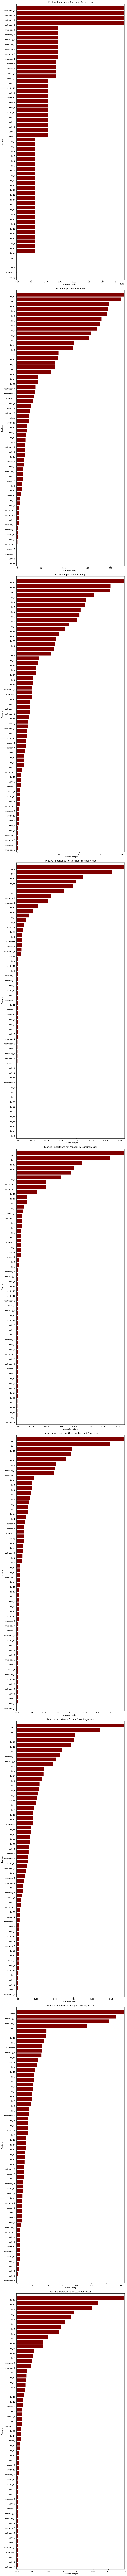

In [11]:
results = main(features, targets['cnt'], test_features, test_targets['cnt'])

In [12]:
display(results)

,Model,Optimal Parameter,Train Accuracy,Validation Accuracy,Test Accuracy,Top Predictors,Run time
0,Linear Regression,NA,0.687713,-6.041738e+24,0.520809,weathersit_3,0.069014
1,Lasso,alpha = 1e-05,0.688740,5.563237e-01,0.464402,hr_17,338.857707
2,Ridge,alpha = 1e-05,0.688740,5.532230e-01,0.464399,hr_17,0.426096
3,Decision Tree Regressor,max_depth = 10,0.762060,5.158503e-01,0.290753,temp,0.393090
4,Random Forest Regressor,max_depth = 10,0.813466,5.823261e-01,0.684354,temp,15.854561
5,Gradient Boosted Regressor,max_depth = 10,0.990293,7.377434e-01,0.791311,temp,22.121017
6,AdaBoost Regressor,max_depth = 10,0.852520,6.441055e-01,0.585313,temp,14.451245
7,LightGBM Regressor,max_depth = 10,0.932655,7.294004e-01,0.803800,temp,1.000225
8,XGB Regressor,max_depth = 10,0.998697,7.537191e-01,0.758548,hr_18,5.078141
9,KNN,k = 2,0.923201,5.508890e-01,0.611440,NA,83.984872
